In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## 1. Autoencoder

In [64]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize data to 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170500096/170498071 [==============================] - 9s 0us/step


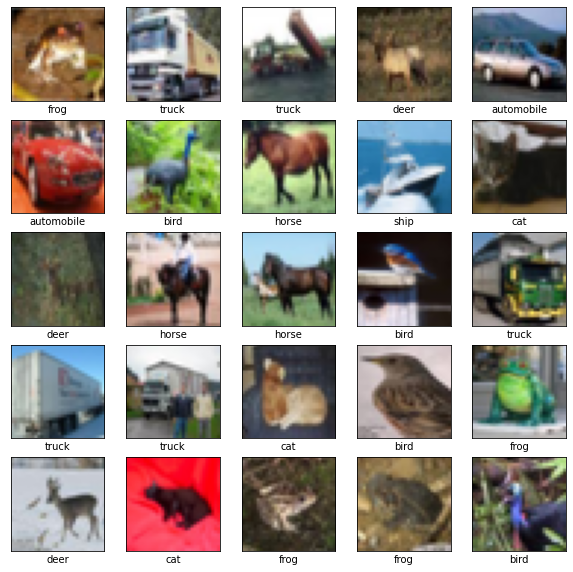

In [65]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

#### Check out sample's shapes

In [94]:
img_shape = train_images.shape[1:]
print(img_shape)
print(np.prod(img_shape))

(32, 32, 3)
3072


In [121]:
input_img = tfkl.Input(shape=img_shape)

x = tfkl.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = tfkl.MaxPooling2D((2, 2), padding='same')(x)
x = tfkl.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = tfkl.MaxPooling2D((2, 2), padding='same')(x)
x = tfkl.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = tfkl.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = tfkl.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = tfkl.UpSampling2D((2, 2))(x)
x = tfkl.Conv2D(8, (3, 3), activation='relu', padding='same')(x)

x = tfkl.UpSampling2D((2, 2))(x)
x = tfkl.Conv2D(16, (3, 3), activation='relu', padding='same')(x)

x = tfkl.UpSampling2D((2, 2))(x)
decoded = tfkl.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 16, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_111 (MaxPoolin (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 8, 8, 8)           584       
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 4, 4, 8)         

In [122]:
history = autoencoder.fit(train_images, train_images,
                epochs=20,
                batch_size=64,
                shuffle=True,
                validation_data=(test_images, test_images),
                callbacks=[EarlyStopping(monitor='val_loss', 
                         patience=5, min_delta=0.0001, restore_best_weights = True)])

Epoch 1/20
782/782 [==============================] - 42s 54ms/step - loss: 0.0236 - val_loss: 0.0167
Epoch 2/20
782/782 [==============================] - 44s 56ms/step - loss: 0.0155 - val_loss: 0.0146
Epoch 3/20
782/782 [==============================] - 43s 56ms/step - loss: 0.0142 - val_loss: 0.0140
Epoch 4/20
782/782 [==============================] - 44s 56ms/step - loss: 0.0136 - val_loss: 0.0133
Epoch 5/20
782/782 [==============================] - 43s 55ms/step - loss: 0.0131 - val_loss: 0.0129
Epoch 6/20
782/782 [==============================] - 42s 54ms/step - loss: 0.0128 - val_loss: 0.0126
Epoch 7/20
782/782 [==============================] - 44s 57ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 8/20
782/782 [==============================] - 43s 55ms/step - loss: 0.0123 - val_loss: 0.0122
Epoch 9/20
782/782 [==============================] - 45s 57ms/step - loss: 0.0121 - val_loss: 0.0120
Epoch 10/20
782/782 [==============================] - 49s 62ms/step - loss: 0.012

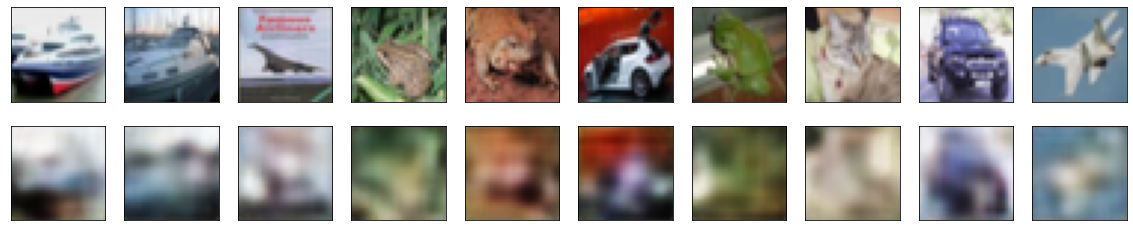

In [124]:
decoded_imgs = autoencoder.predict(test_images)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_images[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2. Image Classification

### 2.1

The CNN has 3 convolution layers, 2 pooling layers, a fully connected layer, and a dropout layer at the end with the dropout rate equals 0.3. All of the convolution layers has kernal size (3,3), stride (1,1), and padding with valid.

In [145]:
image_cnn = Sequential()
image_cnn.add(tfkl.Conv2D(32, 3, activation='relu', 
                          input_shape=(32, 32, 3)))
image_cnn.add(tfkl.MaxPooling2D(2))
image_cnn.add(tfkl.Conv2D(64, 3, activation='relu'))
image_cnn.add(tfkl.MaxPooling2D(2))
image_cnn.add(tfkl.Conv2D(64, 3, activation='relu'))

image_cnn.add(tfkl.Flatten())
image_cnn.add(tfkl.Dense(64, activation='relu'))
image_cnn.add(tfkl.Dropout(rate=0.3))
image_cnn.add(tfkl.Dense(10))

image_cnn.summary() 

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_192 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_131 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_132 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_194 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_24 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)              

The best performance appears at epoch 15, where training accuracy is 77.84% and testing accuracy is 72.23%.

In [146]:
image_cnn.compile(optimizer='adam',
              loss=tfk.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 20

history = image_cnn.fit(train_images, train_labels, epochs=epochs, 
                    validation_data=(test_images, test_labels),
                       callbacks=[EarlyStopping(monitor='val_accuracy', 
                                             patience=5, min_delta=0.0001,
                                            restore_best_weights = True)])

Epoch 1/20
1563/1563 [==============================] - 25s 16ms/step - loss: 1.6156 - accuracy: 0.4085 - val_loss: 1.3074 - val_accuracy: 0.5298
Epoch 2/20
1563/1563 [==============================] - 25s 16ms/step - loss: 1.2535 - accuracy: 0.5542 - val_loss: 1.1257 - val_accuracy: 0.5930
Epoch 3/20
1563/1563 [==============================] - 27s 17ms/step - loss: 1.1168 - accuracy: 0.6057 - val_loss: 1.0327 - val_accuracy: 0.6406
Epoch 4/20
1563/1563 [==============================] - 26s 17ms/step - loss: 1.0219 - accuracy: 0.6427 - val_loss: 0.9809 - val_accuracy: 0.6563
Epoch 5/20
1563/1563 [==============================] - 26s 16ms/step - loss: 0.9481 - accuracy: 0.6699 - val_loss: 0.9273 - val_accuracy: 0.6810
Epoch 6/20
1563/1563 [==============================] - 25s 16ms/step - loss: 0.8930 - accuracy: 0.6882 - val_loss: 0.8737 - val_accuracy: 0.6965
Epoch 7/20
1563/1563 [==============================] - 26s 17ms/step - loss: 0.8477 - accuracy: 0.7043 - val_loss: 0.8579 -

### 2.2 Transfer learning

In [186]:
vgg = VGG16(input_shape=(32,32,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False

x = tfkl.Flatten()(vgg.output)
prediction = tfkl.Dense(10)(x)
vgg_model = Model(inputs=vgg.input, outputs=prediction)
vgg_model.compile(loss=tfk.losses.SparseCategoricalCrossentropy(from_logits=True),
                    optimizer='adam',
                    metrics=['accuracy'])
vgg_model.summary()

Model: "functional_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)       

The best performance appears at the last epoch or epoch afterward, where the training accuracy is 61.36%, and testing accuracy is 59.01%.

In [185]:
epochs = 20

history = vgg_model.fit(train_images, train_labels, epochs=epochs, 
                    validation_data=(test_images, test_labels),
                       callbacks=[EarlyStopping(monitor='val_accuracy', 
                                             patience=5, min_delta=0.0001,
                                            restore_best_weights = True)])

Epoch 1/20
1563/1563 [==============================] - 189s 121ms/step - loss: 1.5347 - accuracy: 0.4777 - val_loss: 1.3757 - val_accuracy: 0.5256
Epoch 2/20
1563/1563 [==============================] - 183s 117ms/step - loss: 1.3101 - accuracy: 0.5525 - val_loss: 1.2987 - val_accuracy: 0.5528
Epoch 3/20
1563/1563 [==============================] - 183s 117ms/step - loss: 1.2514 - accuracy: 0.5717 - val_loss: 1.2647 - val_accuracy: 0.5639
Epoch 4/20
1563/1563 [==============================] - 179s 114ms/step - loss: 1.2179 - accuracy: 0.5815 - val_loss: 1.2471 - val_accuracy: 0.5662
Epoch 5/20
1563/1563 [==============================] - 181s 116ms/step - loss: 1.1962 - accuracy: 0.5888 - val_loss: 1.2313 - val_accuracy: 0.5726
Epoch 6/20
1563/1563 [==============================] - 178s 114ms/step - loss: 1.1806 - accuracy: 0.5958 - val_loss: 1.2270 - val_accuracy: 0.5712
Epoch 7/20
1563/1563 [==============================] - 178s 114ms/step - loss: 1.1687 - accuracy: 0.5968 - val_

## 3. Text Classification

In [2]:
text_df = pd.read_csv('SPAM_detection.csv')

#### Check out the length distribution of each sample

In [4]:
text_df['Message'].apply(lambda x: len(x.split())).describe()

count    5572.000000
mean       15.584171
std        11.406598
min         1.000000
25%         7.000000
50%        12.000000
75%        23.000000
max       171.000000
Name: Message, dtype: float64

#### There are only 65 samples that are longer than 50 words. 50 seems a good length to keep.

In [5]:
sum(text_df['Message'].apply(lambda x: len(x.split())>=50))

65

### Setting up model

In [9]:
MAX_NB_WORDS = 8000
MAX_SEQUENCE_LENGTH = 50
# Word embedding
EMBEDDING_DIM = 50

tokenizer = text.Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(text_df['Message'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9004 unique tokens.


#### There are 9004 unique words, so set max number of words to 8000 should be good

In [36]:
X = tokenizer.texts_to_sequences(text_df['Message'].values)
X = sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = text_df['category_val'].values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (5572, 50)
Shape of label tensor: (5572,)


In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print('Train tensor shape:', X_train.shape,Y_train.shape)
print('Test tensor shape:', X_test.shape,Y_test.shape)

Train tensor shape: (4457, 50) (4457,)
Test tensor shape: (1115, 50) (1115,)


### RNN

In [38]:
# Model setup and training
rnn_model = Sequential()
rnn_model.add(tfkl.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
rnn_model.add(tfkl.LSTM(128, dropout=0.2, recurrent_dropout=0.2))
rnn_model.add(tfkl.Dense(1, activation='sigmoid'))
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
batch_size = 64

history = rnn_model.fit(X_train, Y_train, epochs=epochs, 
                    batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_accuracy', 
                         patience=5, min_delta=0.0001, restore_best_weights = True)])

Epoch 1/20
63/63 [==============================] - 4s 70ms/step - loss: 0.2636 - accuracy: 0.9145 - val_loss: 0.1115 - val_accuracy: 0.9686
Epoch 2/20
63/63 [==============================] - 4s 69ms/step - loss: 0.0496 - accuracy: 0.9845 - val_loss: 0.0749 - val_accuracy: 0.9776
Epoch 3/20
63/63 [==============================] - 4s 70ms/step - loss: 0.0212 - accuracy: 0.9950 - val_loss: 0.0829 - val_accuracy: 0.9731
Epoch 4/20
63/63 [==============================] - 4s 69ms/step - loss: 0.0109 - accuracy: 0.9978 - val_loss: 0.0759 - val_accuracy: 0.9798
Epoch 5/20
63/63 [==============================] - 4s 70ms/step - loss: 0.0064 - accuracy: 0.9983 - val_loss: 0.0850 - val_accuracy: 0.9776
Epoch 6/20
63/63 [==============================] - 4s 68ms/step - loss: 0.0045 - accuracy: 0.9988 - val_loss: 0.0976 - val_accuracy: 0.9776
Epoch 7/20
63/63 [==============================] - 4s 68ms/step - loss: 0.0037 - accuracy: 0.9990 - val_loss: 0.1004 - val_accuracy: 0.9753
Epoch 8/20
63

In [48]:
print("Evaluate on test data")
rnn_results = rnn_model.evaluate(X_test, Y_test)
print("test loss, test acc:", rnn_results)

Evaluate on test data
35/35 [==============================] - 0s 10ms/step - loss: 0.0422 - accuracy: 0.9919
test loss, test acc: [0.04216325655579567, 0.9919282793998718]


### CNN

In [45]:
x_input = tfkl.Input(shape=(MAX_SEQUENCE_LENGTH,))
x = tfkl.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(x_input)
################### add CNN layer
kernel_sizes = [1,2,3,4,5]
pooled_outputs = []
for i in kernel_sizes:
    conv = tfkl.Conv1D(filters = 128, kernel_size = i, padding = 'valid', 
                  activation = 'relu', kernel_initializer = 'he_uniform')(x)
    pool = tfkl.MaxPooling1D(pool_size=MAX_SEQUENCE_LENGTH - i + 1)(conv)
    pooled_outputs.append(pool)
################### 
merged = tfkl.Concatenate(axis=-1)(pooled_outputs)
flatten = tfkl.Flatten()(merged)
drop = tfkl.Dropout(rate=0.4)(flatten)
x_output = tfkl.Dense(1, kernel_initializer='he_uniform', activation='sigmoid')(drop)
cnn_model = Model(inputs=x_input, outputs=x_output)
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
batch_size = 64

history = cnn_model.fit(X_train, Y_train, epochs=epochs, 
                    batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_accuracy', 
                                             patience=5, min_delta=0.0001,
                                            restore_best_weights = True)])

Epoch 1/20
63/63 [==============================] - 1s 23ms/step - loss: 0.3784 - accuracy: 0.8629 - val_loss: 0.3039 - val_accuracy: 0.8453
Epoch 2/20
63/63 [==============================] - 1s 21ms/step - loss: 0.1289 - accuracy: 0.9516 - val_loss: 0.0915 - val_accuracy: 0.9731
Epoch 3/20
63/63 [==============================] - 1s 22ms/step - loss: 0.0301 - accuracy: 0.9923 - val_loss: 0.0810 - val_accuracy: 0.9798
Epoch 4/20
63/63 [==============================] - 1s 21ms/step - loss: 0.0132 - accuracy: 0.9970 - val_loss: 0.0804 - val_accuracy: 0.9798
Epoch 5/20
63/63 [==============================] - 1s 21ms/step - loss: 0.0056 - accuracy: 0.9993 - val_loss: 0.0817 - val_accuracy: 0.9798
Epoch 6/20
63/63 [==============================] - 1s 23ms/step - loss: 0.0030 - accuracy: 0.9998 - val_loss: 0.0860 - val_accuracy: 0.9798
Epoch 7/20
63/63 [==============================] - 1s 22ms/step - loss: 0.0019 - accuracy: 0.9998 - val_loss: 0.0897 - val_accuracy: 0.9821
Epoch 8/20
63

In [47]:
print("Evaluate on test data")
cnn_results = cnn_model.evaluate(X_test, Y_test)
print("test loss, test acc:", cnn_results)

Evaluate on test data
35/35 [==============================] - 0s 2ms/step - loss: 0.0333 - accuracy: 0.9919
test loss, test acc: [0.03332936763763428, 0.9919282793998718]


### ROC

In [52]:
from sklearn.metrics import roc_curve, auc

In [49]:
rnn_preds = rnn_model.predict(X_test).ravel()
cnn_preds = cnn_model.predict(X_test).ravel()

In [53]:
rnn_fpr, rnn_tpr, rnn_thresholds = roc_curve(Y_test, rnn_preds)
cnn_fpr, cnn_tpr, cnn_thresholds = roc_curve(Y_test, cnn_preds)
rnn_auc = auc(rnn_fpr, rnn_tpr)
cnn_auc = auc(cnn_fpr, cnn_tpr)

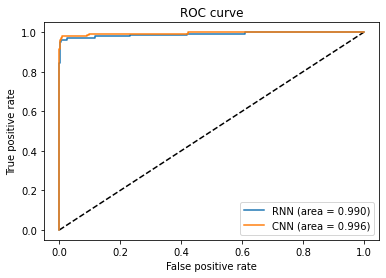

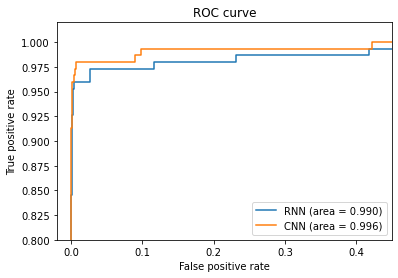

In [62]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rnn_fpr, rnn_tpr, label='RNN (area = {:.3f})'.format(rnn_auc))
plt.plot(cnn_fpr, cnn_tpr, label='CNN (area = {:.3f})'.format(cnn_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Zoom in view of upper left corner
plt.figure(2)
plt.xlim(-0.02, 0.45)
plt.ylim(0.8, 1.02)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rnn_fpr, rnn_tpr, label='RNN (area = {:.3f})'.format(rnn_auc))
plt.plot(cnn_fpr, cnn_tpr, label='CNN (area = {:.3f})'.format(cnn_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()